In [1]:
#IMPORT STATEMENTS
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# **HYPERPARAMETERS**

In [2]:
#HyperParameters
IMG_HEIGHT, IMG_WIDTH = 129,129
SEQUENCE_LENGTH = 10  # Number of frames per video
BATCH_SIZE=50
EPOCHS = 50
NUM_CLASSES = 2

# **Extract Frames**

In [3]:
# Extract frames from a video
def extract_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < SEQUENCE_LENGTH:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH))
        frames.append(frame)
    cap.release()
    if len(frames) == SEQUENCE_LENGTH:
        return np.array(frames)
    return None

# **Load Videos**

In [4]:
# Load videos from folders
def load_videos_from_folder(folder_path, label):
    videos = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".mp4"):  # Assuming videos are in .mp4 format
            video_path = os.path.join(folder_path, filename)
            frames = extract_frames(video_path)
            if frames is not None:
                videos.append(frames)
                labels.append(label)
    return videos, labels

In [5]:
# Load datasets
violent_videos, violent_labels = load_videos_from_folder('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/Violence', label=1)
non_violent_videos, non_violent_labels = load_videos_from_folder('/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset/NonViolence', label=0)

In [6]:
# Combine and Normalize
X = np.array(violent_videos + non_violent_videos)/255.0
Y = np.array(violent_labels + non_violent_labels)

In [7]:
print("Shape of X:",X.shape)
print("Shape of Y",Y.shape)

Shape of X: (1951, 10, 129, 129, 3)
Shape of Y (1951,)


In [8]:
#IMPORT STATEMENTS
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,LSTM,TimeDistributed, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Lambda
from tensorflow.keras.layers import BatchNormalization

2024-10-30 07:19:43.833796: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 07:19:43.833920: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 07:19:43.978498: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **SPLITING THE DATASET**

In [9]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# **MobileNetV2**

In [10]:
from keras.applications.mobilenet_v2 import MobileNetV2
mobilenet= MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

#Fine-Tuning to make the last 40 layer trainable
mobilenet.trainable=True

for layer in mobilenet.layers[:-44]:
  layer.trainable=False

x = mobilenet.output
x = GlobalAveragePooling2D()(x)
cnn_model = Model(inputs=mobilenet.input, outputs=x)

/tmp/ipykernel_34/2177351994.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet= MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **COMBINE CNN AND LSTM**

In [11]:
model = Sequential()
model.add(TimeDistributed(cnn_model, input_shape=(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(LSTM(32, return_sequences=False)) 

# Add Batch Normalization after LSTM
model.add(BatchNormalization())

model.add(Dropout(0.6))
model.add(Dense(32, activation='relu'))  

# Add Batch Normalization before final Dense layer
model.add(BatchNormalization())

model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **SUMMARY**

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │       168,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,427,393 (9.26 MB)

 Trainable params: 1,912,449 (7.30 MB)

 Non-trainable params: 514,944 (1.96 MB)

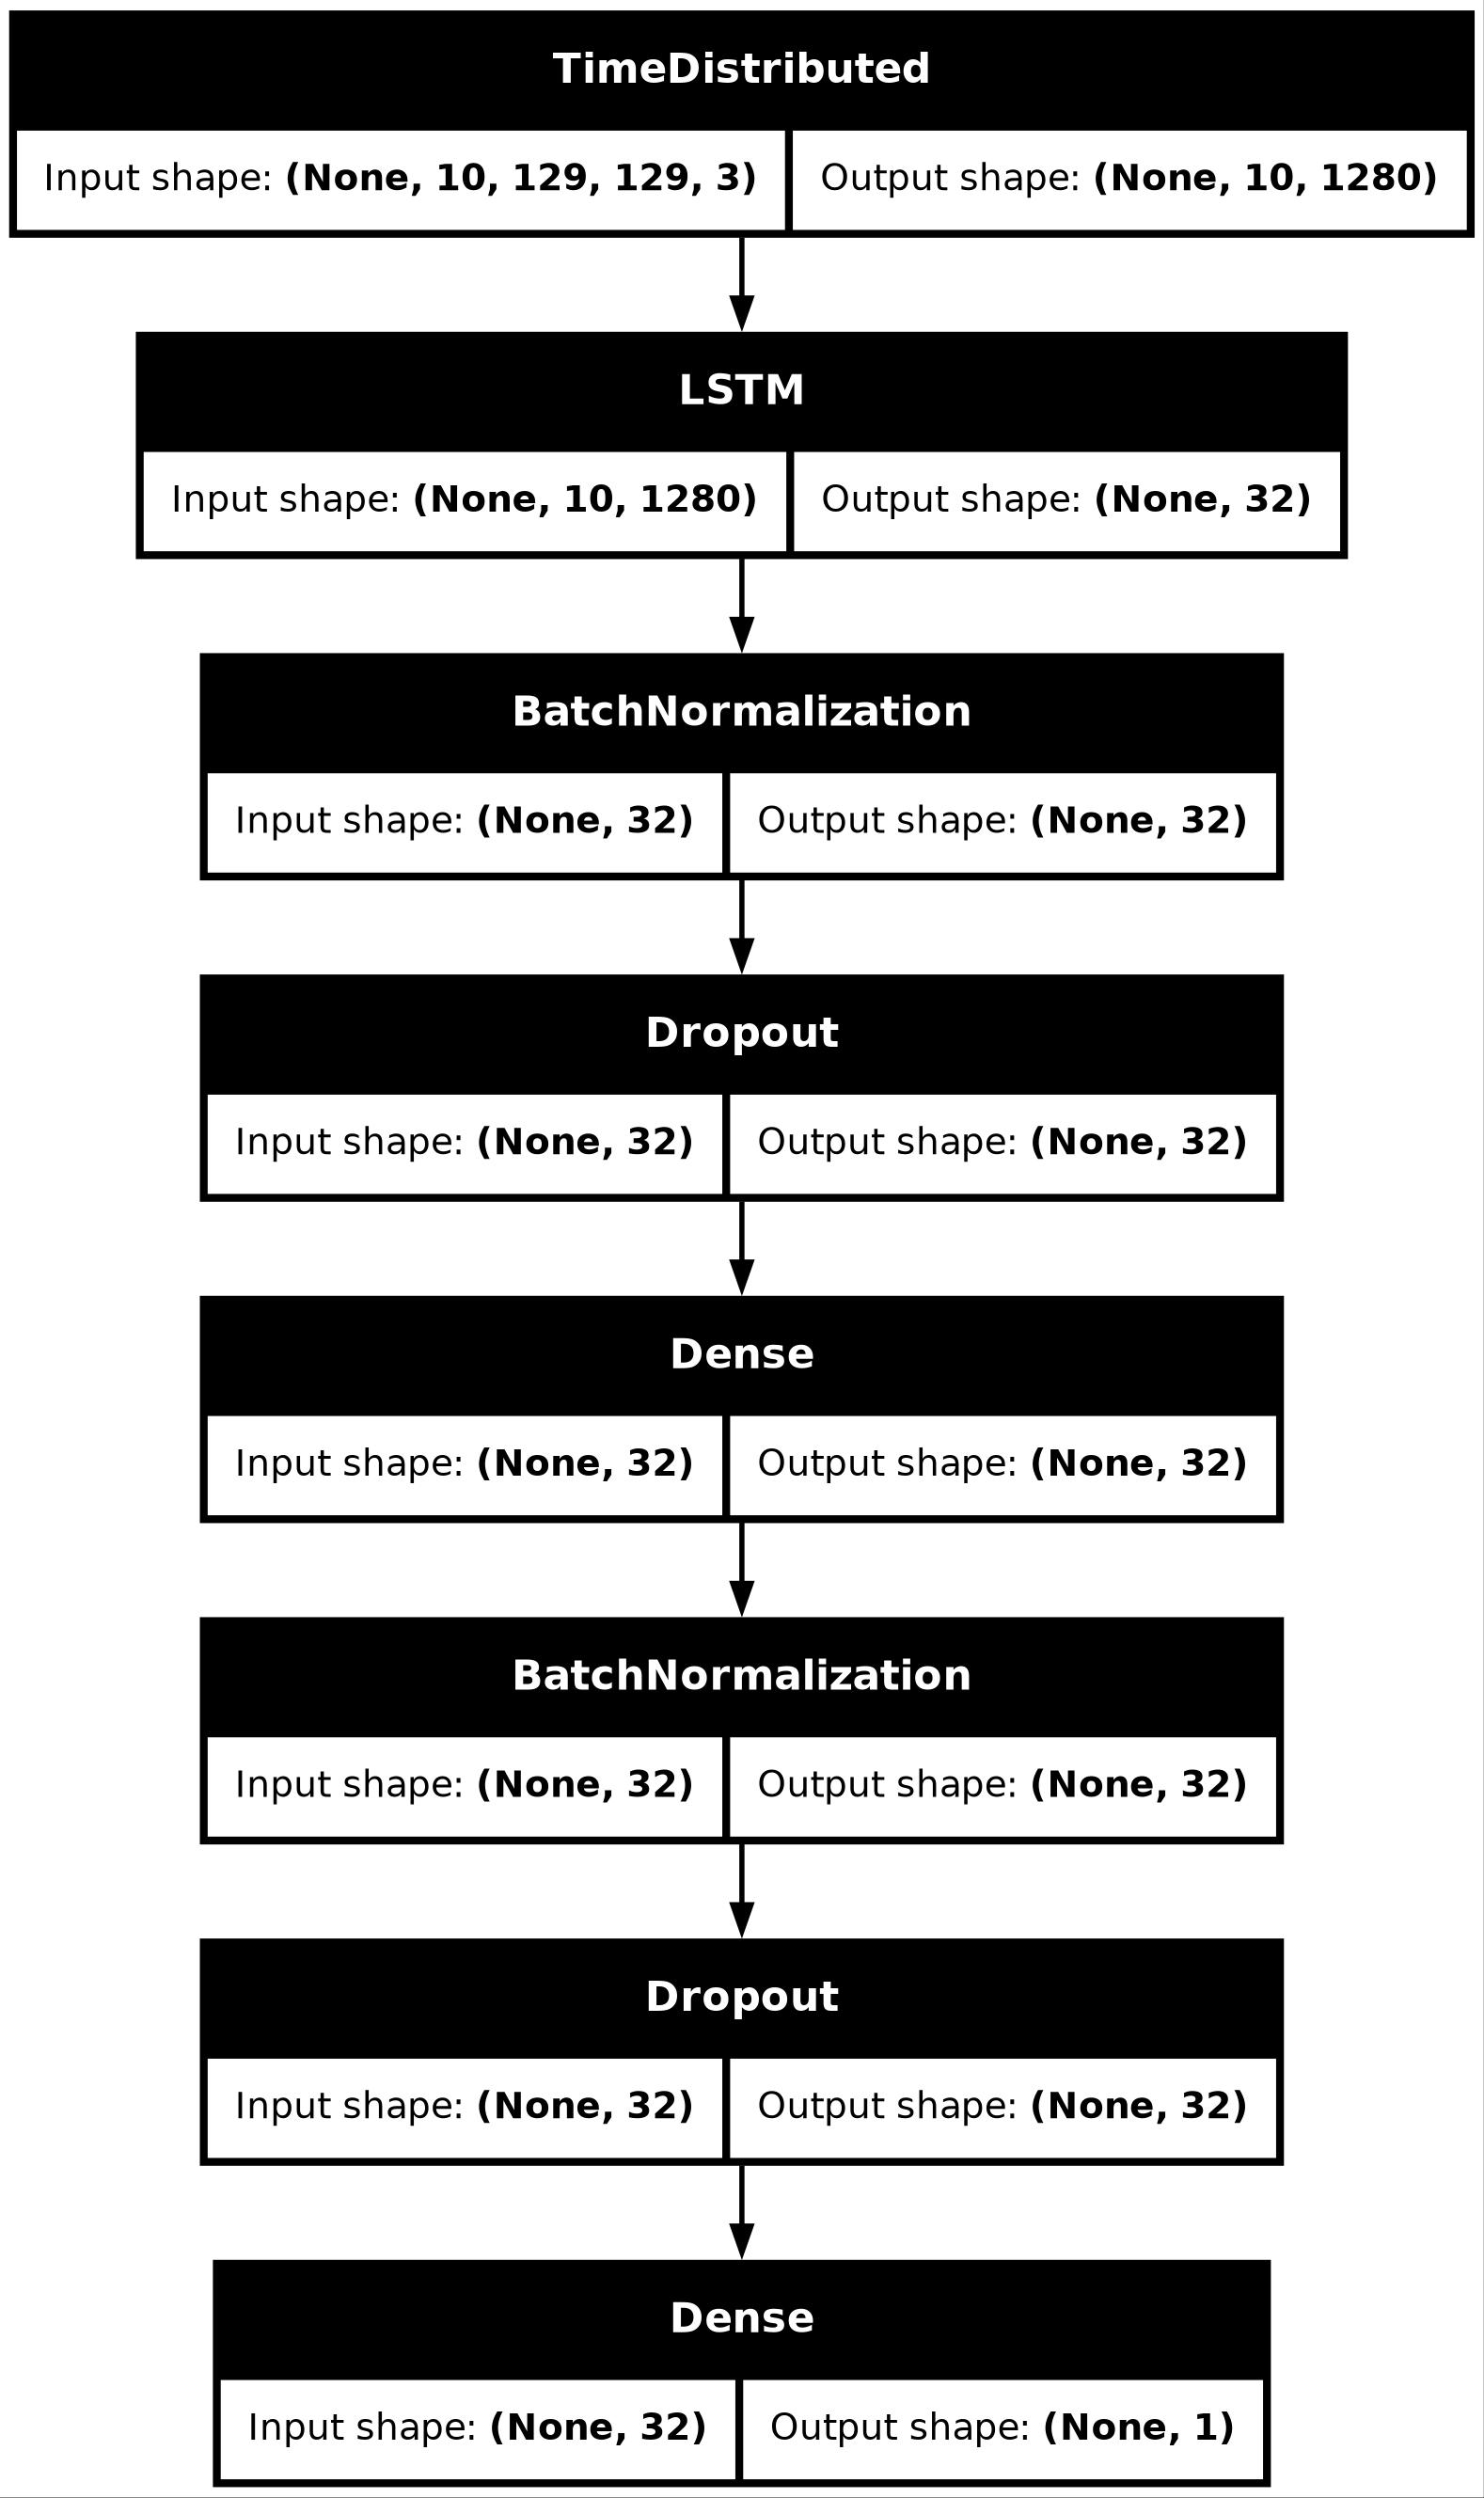

In [13]:
from tensorflow.keras.utils import plot_model
# Visualize and save the model architecture
plot_model(model, to_file="model.jpg", show_shapes=True)


# **COMPILE THE MODEL**

In [14]:
# Compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# **CALLBACKS**

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
                monitor='val_loss',  
                patience=10, 
                verbose=1)

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.6,          # Factor by which the learning rate will be reduced
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode
    min_lr=0.0005        # Lower bound on the learning rate
)

# **Train the Model**

In [17]:
# Train the model
history=model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2,callbacks=[early_stopping,reduce_lr])

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5254 - loss: 1.0567 - val_accuracy: 0.6795 - val_loss: 0.5905 - learning_rate: 0.0100
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 562ms/step - accuracy: 0.6874 - loss: 0.6365 - val_accuracy: 0.7372 - val_loss: 0.5297 - learning_rate: 0.0100
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 564ms/step - accuracy: 0.7664 - loss: 0.4938 - val_accuracy: 0.7244 - val_loss: 0.5060 - learning_rate: 0.0100
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 569ms/step - accuracy: 0.7900 - loss: 0.4283 - val_accuracy: 0.7692 - val_loss: 0.4623 - learning_rate: 0.0100
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 576ms/step - accuracy: 0.8441 - loss: 0.3408 - val_accuracy: 0.8205 - val_loss: 0.3751 - learning_rate: 0.0100
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 581ms/step - accuracy: 0.8924 - loss: 0.2674 - val_accuracy: 0.8494 - val_loss: 0.3338 - learning_rate: 0.0100
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 590ms/step - accuracy: 0.9137 - loss: 0.248

# **Accuracy Curve**

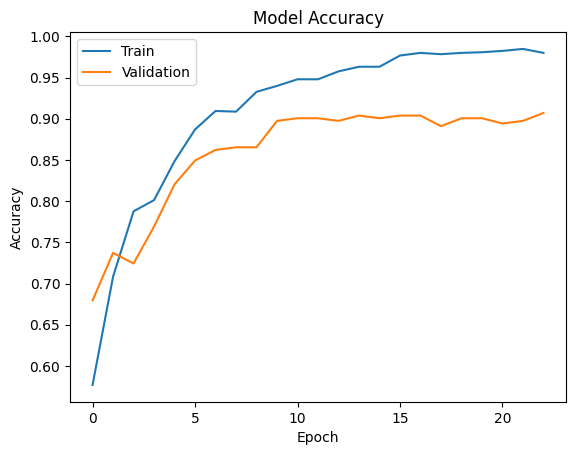

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("accuracy_curve.jpg")  # Save the figure before showing it
plt.show()  # Display the plot

# **Loss Curve**

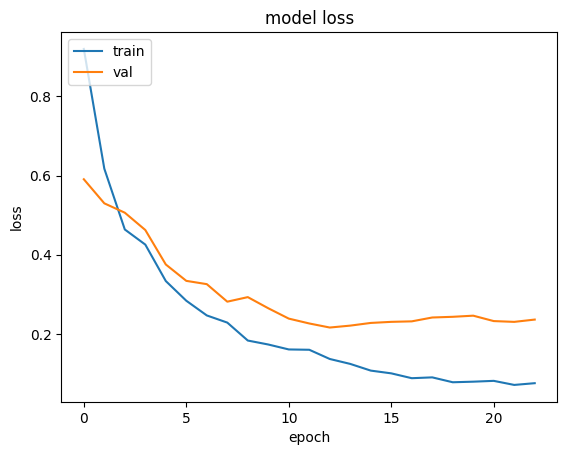

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_curve.jpg")
plt.show()

In [20]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy:.2f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 256ms/step - accuracy: 0.9051 - loss: 0.2542
Test Accuracy: 0.91


In [21]:
pred=model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step 


In [22]:
pred.shape

(391, 1)

# **Confusion Matrix**

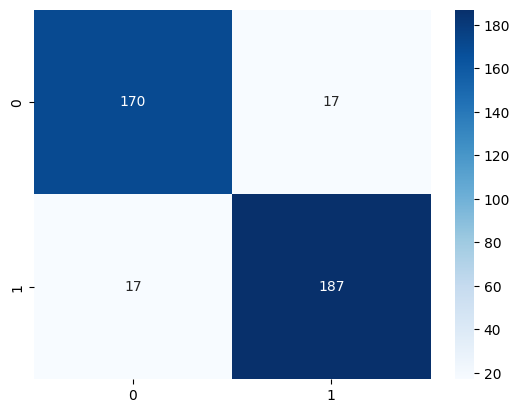

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert predicted probabilities to binary values (0 or 1)
pred_binary = (pred > 0.5).astype(int)

cm = confusion_matrix(y_test, pred_binary)
sns.heatmap(cm, annot=True, fmt='d',cmap="Blues")
plt.savefig("confusion_matrix.jpg")

In [24]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_binary))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       187
           1       0.92      0.92      0.92       204

    accuracy                           0.91       391
   macro avg       0.91      0.91      0.91       391
weighted avg       0.91      0.91      0.91       391



In [25]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Precision:",precision_score(y_test,pred_binary))
print("Recall:",recall_score(y_test,pred_binary))
print("F1-Score:",f1_score(y_test,pred_binary))

Precision: 0.9166666666666666
Recall: 0.9166666666666666
F1-Score: 0.9166666666666666


#Save the model

In [26]:
model.save('violence_detection_MobileNet_Lstm_model.h5')